## Predicción del porcentaje de voto de VOX con XGBoost en SageMaker 
(prueba BATCH_TRANSFORM en jupyter notebook)

Como introducción a uso de SageMaker, elegimos el dataset de NOV19 para predecir el porcentaje de voto a Vox.


In [1]:
#!pip install sagemaker==1.72.0

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

#from sklearn.datasets import load_boston
import sklearn.model_selection

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Además de las librerías típicas seleccionadas arriba necesitamos instalar SageMaker.

In [3]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. 
# IAM = Identity and Access Management
role = get_execution_role()

### Carga de datos


In [4]:
strings = {'Sección' : 'str', 'cod_ccaa' : 'str', 'cod_prov' : 'str', 'cod_mun' : 'str'}

In [10]:
Información necesaria de S3 para acceder a los datos. 
bucket_name = 'arn:aws:s3:::electomedia' 
file_key = 'datos-elecciones-generales-unificados/gen_N19_unif_cols_prov_copia.txt'


s3uri = 's3://electomedia/datos-elecciones-generales-unificados/gen_N19_unif_cols_prov_copia.txt'

df_eleccion = pd.read_csv(s3uri)

df_eleccion.head()

,Sección,cod_ccaa,cod_prov,cod_mun,cod_sec,CCAA,Provincia,Municipio,Censo_Esc,Votos_Total,Participación,Nulos,Votos_Válidos,Blanco,V_Cand,PP,PSOE,Cs,UP,IU,VOX,UPyD,MP,CiU,ERC,JxC,CUP,DiL,PNV,Bildu,Amaiur,CC,FA,TE,BNG,PRC,GBai,Compromis,PACMA,Otros,% PP,% PSOE,% UP,% Vox,% Cs,% IU,Ganador,Segundo,Tercero,Cuarto,Quinto,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100 y más,Población Total,Hombres,Mujeres,% mayores 65 años,% 20-64 años,% menores 19 años,Afiliados SS Minicipio,% Afiliados SS autónomos,% Afiliados SS / Población,Paro Registrado Municipio,% Paro Hombres,% Paro mayores 45,% Paro s/ Afiliados SS Municipio,Renta persona 2017,Renta persona 2015,Renta hogar 2017,Renta hogar 2015,Renta Salarios 2018,Renta Salarios 2015,Renta Pensiones 2018,Renta Pensiones 2015,Renta Desempleo 2018,Renta Desempleo 2015,dict_res,dict_res_ord
0,022019111010400101001,1,4,4001,400101001,Andalucía,Almería,Abla,1002,717,0.715569,7,710,3,707,193,310,47,30,0,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,0.271831,0.436620,0.042254,0.171831,0.066197,0.0,PSOE,PP,VOX,Cs,UP,39.0,42.0,47.0,47.0,70.0,72.0,73.0,80.0,89.0,81.0,94.0,87.0,91.0,77.0,72.0,42.0,67.0,56.0,19.0,4.0,0.0,1249.0,635.0,614.0,0.269816,0.590072,0.140112,304.0,0.223684,0.243395,140.0,0.421429,0.550000,0.315315,9159.0,8788.0,20172.0,19546.0,5574.0,4833.0,3286.0,3082.0,403.0,471.0,"{'PP': 193, 'PSOE': 310, 'Cs': 47, 'UP': 30, 'IU': 0, 'VOX': 122, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 3, 'Otros': 2}","[('PSOE', 310), ('PP', 193), ('VOX', 122), ('Cs', 47), ('UP', 30), ('PACMA', 3), ('Otros', 2), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0)]"
1,022019111010400201001,1,4,4002,400201001,Andalucía,Almería,Abrucena,1013,711,0.701876,12,699,1,698,111,349,45,42,0,147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.158798,0.499285,0.060086,0.210300,0.064378,0.0,PSOE,VOX,PP,Cs,UP,30.0,30.0,33.0,41.0,71.0,79.0,60.0,75.0,70.0,70.0,108.0,101.0,99.0,86.0,61.0,64.0,61.0,46.0,14.0,2.0,1.0,1202.0,637.0,565.0,0.278702,0.609817,0.111481,298.0,0.251678,0.247920,179.0,0.379888,0.625698,0.375262,8827.0,8107.0,17841.0,17115.0,4640.0,4048.0,3418.0,2770.0,568.0,620.0,"{'PP': 111, 'PSOE': 349, 'Cs': 45, 'UP': 42, 'IU': 0, 'VOX': 147, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 2, 'Otros': 2}","[('PSOE', 349), ('VOX', 147), ('PP', 111), ('Cs', 45), ('UP', 42), ('PACMA', 2), ('Otros', 2), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 0), ('JxC', 0), ('CUP', 0), ('DiL', 0), ('PNV', 0), ('Bildu', 0), ('Amaiur', 0), ('CC', 0), ('FA', 0), ('TE', 0), ('BNG', 0), ('PRC', 0), ('GBai', 0), ('Compromis', 0)]"
2,022019111010400301001,1,4,4003,400301001,Andalucía,Almería,Adra,667,484,0.725637,7,477,5,472,176,128,15,34,0,116,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0.368973,0.268344,0.071279,0.243187,0.031447,0.0,PP,PSOE,VOX,UP,Cs,36.0,28.0,44.0,40.0,63.0,64.0,54.0,54.0,54.0,61.0,82.0,75.0,67.0,48.0,37.0,40.0,26.0,15.0,3.0,1.0,0.0,892.0,435.0,457.0,0.190583,0.643498,0.165919,7968.0,0.382530,8.932735,2525.0,0.432871,0.473663,0.240637,8965.0,8267.0,26498.0,24688.0,5121.0,4795.0,2499.0,2301.0,337.0,333.0,"{'PP': 176, 'PSOE': 128, 'Cs': 15, 'UP': 34, 'IU': 0, 'VOX': 116, 'UPyD': 0, 'MP': 0, 'CiU': 0, 'ERC': 0, 'JxC': 0, 'CUP': 0, 'DiL': 0, 'PNV': 0, 'Bildu': 0, 'Amaiur': 0, 'CC': 0, 'FA': 0, 'TE': 0, 'BNG': 0, 'PRC': 0, 'GBai': 0, 'Compromis': 0, 'PACMA': 3, 'Otros': 0}","[('PP', 176), ('PSOE', 128), ('VOX', 116), ('UP', 34), ('Cs', 15), ('PACMA', 3), ('IU', 0), ('UPyD', 0), ('MP', 0), ('CiU', 0), ('ERC', 

In [7]:
df_eleccion.head().T

,0,1,2,3,4
Sección,022019111010400101001,022019111010400201001,022019111010400301001,022019111010400301002,022019111010400301003
cod_ccaa,01,01,01,01,01
cod_prov,04,04,04,04,04
cod_mun,04001,04002,04003,04003,04003
cod_sec,400101001,400201001,400301001,400301002,400301003
CCAA,Andalucía,Andalucía,Andalucía,Andalucía,Andalucía
Provincia,Almería,Almería,Almería,Almería,Almería
Municipio,Abla,Abrucena,Adra,Adra,Adra
Censo_Esc,1002,1013,667,1306,1551
Votos_Total,717,711,484,909,975


In [11]:
df_eleccion.columns

Index(['Sección', 'cod_ccaa', 'cod_prov', 'cod_mun', 'cod_sec', 'CCAA',
       'Provincia', 'Municipio', 'Censo_Esc', 'Votos_Total', 'Participación',
       'Nulos', 'Votos_Válidos', 'Blanco', 'V_Cand', 'PP', 'PSOE', 'Cs', 'UP',
       'IU', 'VOX', 'UPyD', 'MP', 'CiU', 'ERC', 'JxC', 'CUP', 'DiL', 'PNV',
       'Bildu', 'Amaiur', 'CC', 'FA', 'TE', 'BNG', 'PRC', 'GBai', 'Compromis',
       'PACMA', 'Otros', '% PP', '% PSOE', '% UP', '% Vox', '% Cs', '% IU',
       'Ganador', 'Segundo', 'Tercero', 'Cuarto', 'Quinto', '0-4', '5-9',
       '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayo

In [12]:
df_eleccion['% Vox'].describe()

count    36299.000000
mean         0.149372
std          0.080258
min          0.000000
25%          0.088054
50%          0.149819
75%          0.201411
max          0.666667
Name: % Vox, dtype: float64

In [11]:
df_eleccion['% Vox'].isna().sum()

3

In [4]:
#df_eleccion.loc[df_eleccion['% Vox'].isna()]

In [14]:
df_eleccion['VOX'].sum()

3640377

In [5]:
#df_eleccion.info()

In [13]:
#añado CCAA y me cargo 0-4,5-9,10-14
cols_validas = ['% Vox','CCAA','Provincia',
        'Censo_Esc', 'Participación',
         '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [15]:
df_eleccion = df_eleccion[cols_validas]

In [6]:
#df_eleccion.info()

In [17]:
FillNA_num_mean = ['Censo_Esc', 'Participación','15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49',
       '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89',
       '90-94', '95-99', '100 y más', 'Población Total', 'Hombres', 'Mujeres',
       '% mayores 65 años', '% 20-64 años', '% menores 19 años',
       'Afiliados SS Minicipio', '% Afiliados SS autónomos',
       '% Afiliados SS / Población', 'Paro Registrado Municipio',
       '% Paro Hombres', '% Paro mayores 45',
       '% Paro s/ Afiliados SS Municipio', 'Renta persona 2017',
       'Renta persona 2015', 'Renta hogar 2017', 'Renta hogar 2015',
       'Renta Salarios 2018', 'Renta Salarios 2015', 'Renta Pensiones 2018',
       'Renta Pensiones 2015', 'Renta Desempleo 2018', 'Renta Desempleo 2015']

In [18]:
for item in FillNA_num_mean:
        
    df_eleccion[item].fillna(df_eleccion[item].mean(), inplace=True)

In [19]:
categorical = ['Provincia']

In [20]:
df_eleccion['Provincia'].value_counts().sum()

36302

In [21]:
mean_map1 = {}
for c in categorical:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_eleccion.groupby(c)['% Vox'].mean()
    df_eleccion[c] = df_eleccion[c].map(mean)    
    mean_map1[c] = mean

In [7]:
#mean_map1

In [23]:
categorical2 = ['CCAA']

In [24]:
categorical2

['CCAA']

In [25]:
mean_map2 = {}
for c in categorical2:
    
    # df_filtered[c].fillna(df_filtered[c].mode()[0], inplace=True)
    
    mean = df_eleccion.groupby(c)['% Vox'].mean()
    df_eleccion[c] = df_eleccion[c].map(mean)    
    mean_map2[c] = mean

In [8]:
#mean_map2

In [9]:
#df_eleccion.info()

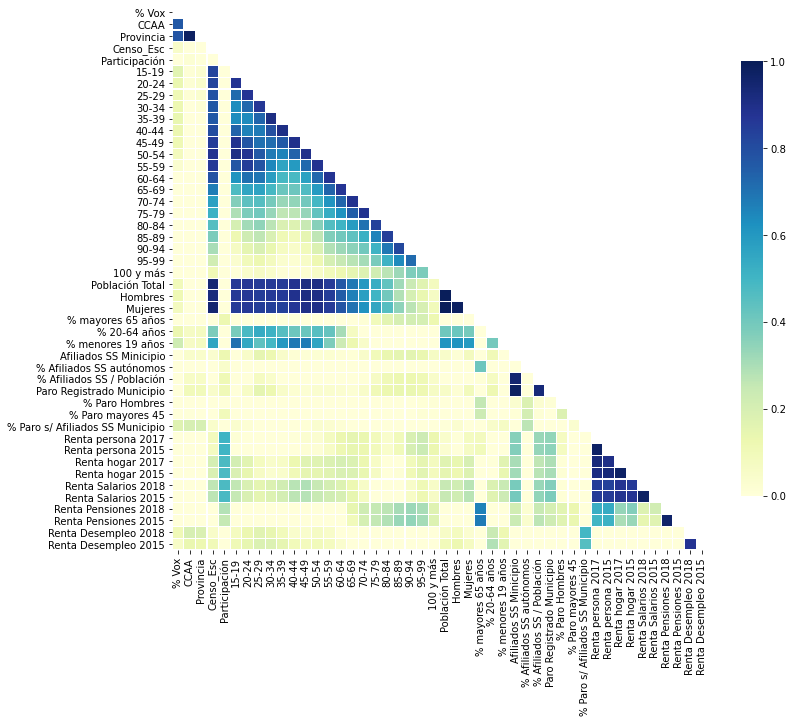

In [28]:
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df_eleccion).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [29]:
df_eleccion = df_eleccion.drop(['Renta persona 2015', 'Renta hogar 2015', 'Renta Salarios 2015', 'Renta Pensiones 2015', 'Renta Desempleo 2015', 'Hombres', 'Mujeres'], axis = 1)

In [30]:
df_eleccion['% Vox'].isna().sum() 

3

In [31]:
df_eleccion = df_eleccion[df_eleccion['% Vox'].notnull()]

In [ ]:
#datos limpios y numéricos. AHORA TOCA DIVIDIR EN TRAIN TEST Y X E Y

### Split de los datos



In [33]:
data = df_eleccion.values
y = data[:,0:1]     
X = data[:,1:]      
feature_names = df_eleccion.columns[1:]
X_dfN19_pd = pd.DataFrame(X, columns= feature_names)
Y_dfN19_pd = pd.DataFrame(y)

#  2/3 training y  1/3 testing.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_dfN19_pd, Y_dfN19_pd, test_size=0.33)

# Después otra vez train se divide en 2/3 training y 1/3 validation.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

### Carga de datos a s3

Cuando se construye un job con SM se genera un container que ejecuta el training y se conecta a s3.  
Aquí primero guardamos en local y luego los subimos a s3. 

In [34]:
data_dir = 'data/N19'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [35]:
# Importante en el caso de amazon es quitar el header para que funcione el algoritmo. 
# Además la primera columna se asume que contiene la variable target.  

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [36]:
prefix = 'N19-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### Train del modelo XGBoost

Empezamos probando con XGBoost porque nos permite probar con un container ya facilitado por amazon y ahorrarnos algunas configuraciones de más bajo nivel que probaremos más adelante.  


In [37]:
container = get_image_uri(session.boto_region_name, 'xgboost')

#from sagemaker import image_uris OTRA OPCIÓN SI ESA FALLA, ya que iba a ser deprecated
#container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")

# construimos el objeto para la estimación. 
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use 
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Definimos hiperparámetros. Este es sólo un ejemplo. 

In [38]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

Llega el momento del training. hay que asegurarse de que SM sabe que el formato es csv. 


In [39]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2021-08-24 13:03:49 Starting - Starting the training job...........................
2021-08-24 13:08:08 Starting - Launching requested ML instances.........
2021-08-24 13:09:22 Starting - Preparing the instances for training......
2021-08-24 13:10:49 Downloading - Downloading input data...
2021-08-24 13:11:21 Training - Downloading the training image...
2021-08-24 13:11:47 Uploading - Uploading generated training modelArguments: train
[2021-08-24:13:11:42:INFO] Running standalone xgboost training.
[2021-08-24:13:11:42:INFO] File size need to be processed in the node: 8.93mb. Available memory size in the node: 8432.02mb
[2021-08-24:13:11:42:INFO] Determined delimiter of CSV input is ','
[13:11:42] S3DistributionType set as FullyReplicated
[13:11:42] 16294x38 matrix with 619172 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2021-08-24:13:11:42:INFO] Determined delimiter of CSV input is ','
[13:11:42] S3DistributionType set as FullyReplicated
[13:11:42

## Test

Una vez hecho el fit, con los datos de test se puede probar el modelo usando batch transform. 
Es una funcionalidad que permite recurrir a un modelo ya entrenado para validar nuevos datos sin necesidad de desplegar un endpoint. 


In [40]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [41]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [42]:

xgb_transformer.wait()

...................................Arguments: serve
Arguments: serve
[2021-08-24 13:20:11 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2021-08-24 13:20:11 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2021-08-24 13:20:11 +0000] [1] [INFO] Using worker: gevent
[2021-08-24 13:20:11 +0000] [20] [INFO] Booting worker with pid: 20
[2021-08-24 13:20:11 +0000] [21] [INFO] Booting worker with pid: 21
/opt/amazon/lib/python3.7/site-packages/gunicorn/workers/ggevent.py:65: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.util.ssl_ (/opt/amazon/lib/python3.7/site-packages/urllib3/util/ssl_.py)', 'urllib3.util (/opt/amazon/lib/python3.7/site-packages/urllib3/util/__init__.py)']. 
  monkey.patch_all(subproc

Una vez terminado el transform job los datos se guardan en s3 pero los podemos descargar. 

In [43]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-550102314018/xgboost-2021-08-24-13-14-32-766/test.csv.out to data/N19/test.csv.out


Una forma de probar nuestro modelo sería con el siguiente scatter plot entre y-predicted e y-test. Puede mejorar. 

In [44]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median vote percentage vs Predicted vote percentage')

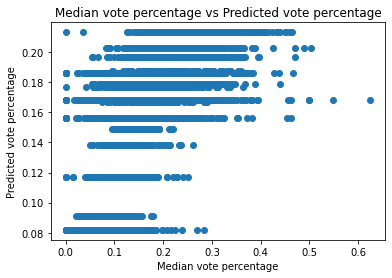

In [45]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median vote percentage")
plt.ylabel("Predicted vote percentage")
plt.title("Median vote percentage vs Predicted vote percentage")

## Importante: 
Acordarse de borrar endpoints, modelos y logs...
